# Projected gradient method for bound (box) contraints

We consider a quadratic cost function with bound (box) constraints

\begin{align}
\underset{\mathbf x\in\mathrm R^n}{\text{minimize}} & \qquad\qquad \frac{1}{2}\mathbf x^T \mathbf Q \mathbf x + \mathbf c^T \mathbf x\\
\text{subject to} & \qquad\qquad \mathbf x_\mathrm{l} \leq \mathbf x \leq \mathbf x_\mathrm{u}.
\end{align}

## Projection on a box

In [1]:
function projection_on_box!(x,xl,xu)
    for i=1:length(x)
        if x[i] < xl[i]
            x[i] = xl[i]
        elseif x[i] > xu[i]
            x[i] = xu[i]
        end
    end
end

projection_on_box! (generic function with 1 method)

## Projected gradient algorithm with a constant step length

In [2]:
using LinearAlgebra

In [3]:
function projected_gradient_quadratic(Q,c,xl,xu,x0,ϵ,N)
    x = x0                           # initializing x
    g(x) = Q*x+c                     # building the gradient
    L = maximum(diag(Q,0))           # maximum curvature (here I assume just diagonal Q, otherwise max(eigvals))
    α = 1/L                          # step length
    iter = 0
    d = 1+ϵ                          # initial value of the distance between two solutions (epsilon plus whatever)
    while (norm(d) > ϵ/L) && iter <= (N-1)
        xold = x
        x = x - α*g(x)               # the step in the descent direction
        projection_on_box!(x,xl,xu)  # the projection of the descent step on the box
        d = x-xold                   # the current step (after the projection)
        iter = iter+1
    end
    return 1/2*dot(x,Q*x)+dot(x,c),x
end

projected_gradient_quadratic (generic function with 1 method)

## Application to some concrete data

In [4]:
x0 = [1.5, 1.5]     # the initial vector

xl = [0.0, 0.0]     # lower bound
xu = [2.0, 2.0]     # upper bound

Q = [1 0; 0 3]      # the positive definite matrix defining the quadratic form
c = [1; 2]          # the vector defining the linear part

ϵ  = 1e-5           # the tolerance
N  = 100;          # the maximum number of steps 

In [5]:
f_opt,x_opt = projected_gradient_quadratic(Q,c,xl,xu,x0,ϵ,N)

(0.0, [0.0, 0.0])

A more "decorated" version

In [6]:
using Printf, LinearAlgebra

In [7]:
function projected_gradient_quadratic(Q,c,xl,xu,x0,ϵ,N)
    x = x0                    # initializing x
    X = x                     # the vector of vectors that will be output
    f(x) = 1/2*dot(x,Q*x)+dot(x,c)
    fx = f(x)
    F = [fx,]
    g(x) = Q*x+c              # building the gradient
    gx = g(x)
    L = maximum(diag(Q,0))    # maximum curvature (here I assume just diagonal Q, otherwise max(eigvals))
    α = 1/L                   # step length
    iter = 0
    d = 1
    while (norm(d) > ϵ/L) && iter<=(N-1)
        iter = iter+1
        xold = x
        x = x - α*gx          # step in the descent direction
        projection_on_box!(x,xl,xu)
        d = x-xold
        @printf("iter = %3d   ||∇f(x)|| = %6.4e   f(x) = %6.4e\n",iter,norm(gx),fx)
        gx = g(x)
        fx = f(x)
        X = hcat(X,x)
        push!(F,fx)
    end
    return F,X
end

projected_gradient_quadratic (generic function with 1 method)

In [8]:
F,X = projected_gradient_quadratic(Q,c,xl,xu,x0,ϵ,N)

iter =   1   ||∇f(x)|| = 6.9642e+00   f(x) = 9.0000e+00
iter =   2   ||∇f(x)|| = 2.6034e+00   f(x) = 8.8889e-01
iter =   3   ||∇f(x)|| = 2.2879e+00   f(x) = 1.1728e-01
iter =   4   ||∇f(x)|| = 2.2361e+00   f(x) = 0.0000e+00


([9.0, 0.8888888888888891, 0.117283950617284, 0.0, 0.0], [1.5 0.6666666666666667 … 0.0 0.0; 1.5 0.0 … 0.0 0.0])

## Plotting

In [9]:
x1_data = x2_data = -2:0.01:4;
f(x) = 1/2*dot(x,Q*x)+dot(x,c)
z_data = [f([x1,x2]) for x2=x2_data, x1=x1_data];

In [10]:
xs = -Q\c           # the stationary point of the unconstrained problem 

2-element Array{Float64,1}:
 -1.0
 -0.6666666666666666

In [11]:
using Plots, LaTeXStrings
pyplot()

Plots.PyPlotBackend()

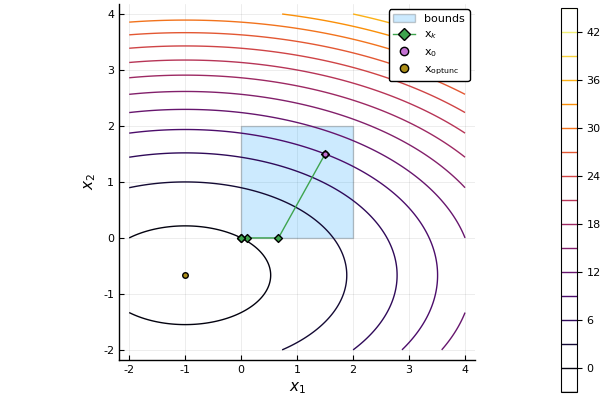

In [12]:
plot(Shape([(2,2),(2,0),(0,0),(0,2),(2,2)]),opacity=0.2,label="bounds")
contour!(x1_data,x2_data,z_data)
plot!(X[1,:],X[2,:],label=L"$\mathrm{x}_k$",marker=:diamond,aspect_ratio=1)
scatter!([x0[1],],[x0[2],],label=L"$\mathrm{x}_0$")
scatter!([xs[1],],[xs[2],],label=L"$\mathrm{x}_\mathrm{opt unc}$")
xlabel!(L"$x_1$");ylabel!(L"$x_2$");
#xlims!(-4,4); ylims!(-4,4)